In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import hypernetx as hnx
from utils import *
import hypernetx.algorithms.hypergraph_modularity as hmod
import community as community_louvain

## Create synthetic data

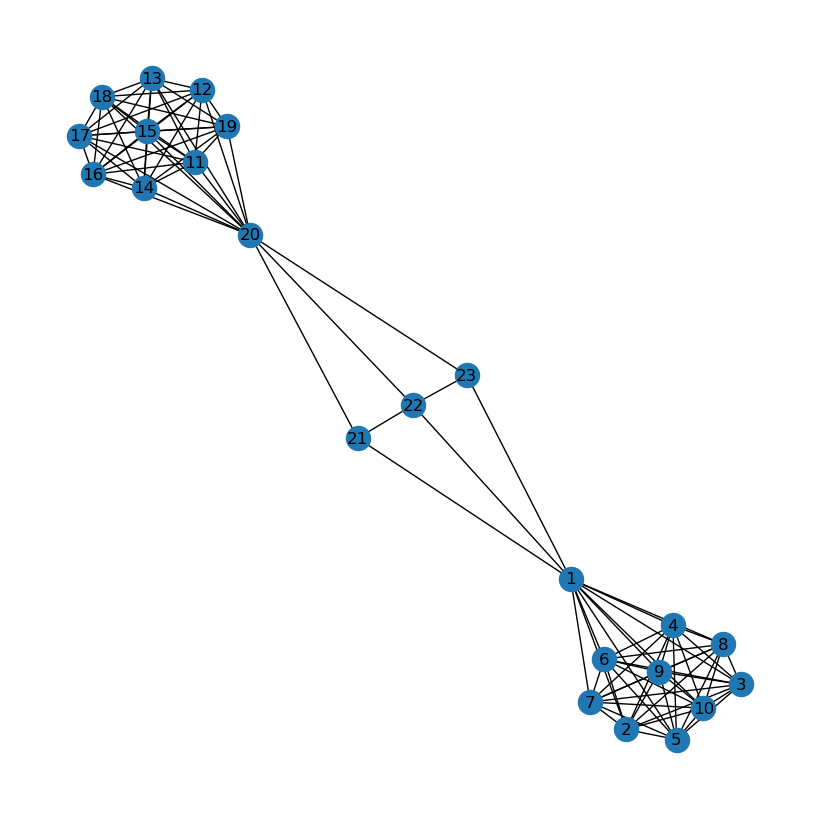

In [2]:
n = 10 # size of Kn
m = 2 # number of triangles is 2n

G1 = nx.complete_graph(range(1, n+1))
G2 = nx.complete_graph(range(n+1, 2*n+1))

G = nx.union(G1, G2)

for i in range(1, m+1):
    G.add_edge(2*n+i, 2*n+i+1)
    G.add_edge(1, 2*n+i)
    G.add_edge(2*n, 2*n+i)
    G.add_edge(1, 2*n+i+1)
    G.add_edge(2*n, 2*n+i+1)

triangle_list = pd.DataFrame(columns=['node_1', 'node_2', 'node_3'])

for i in range(1, m+1):
    triangle_list.loc[len(triangle_list.index)] = [1, 2*n+i, 2*n+i+1]
    triangle_list.loc[len(triangle_list.index)] = [2*n, 2*n+i, 2*n+i+1]

nx.draw(G, with_labels = True)

## Kaminski et al.

In [3]:
edge_list = pd.DataFrame([e for e in G.edges])
h_graph = hgraph_from_lists(edge_list, triangle_list)

In [4]:
HG = hmod.precompute_attributes(h_graph)
K = hmod.kumar(HG)
K_strict = hmod.last_step(HG, K, hmod.strict)
K_maj = hmod.last_step(HG, K, hmod.majority)
K_linear = hmod.last_step(HG, K, hmod.linear)

In [5]:
K_strict, K_linear, K_maj

([{1, 2, 3, 4, 5, 6, 7, 8, 9, 10},
  {11, 12, 13, 14, 15, 16, 17, 18, 19},
  {20, 21, 22, 23}],
 [{1, 2, 3, 4, 5, 6, 7, 8, 9, 10},
  {11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
  {21, 22, 23}],
 [{1, 2, 3, 4, 5, 6, 7, 8, 9, 10},
  {11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
  {21, 22, 23}])

In [6]:
hgraph_mod_strict = hmod.modularity(HG, K_strict, hmod.strict)
hgraph_mod_maj =    hmod.modularity(HG, K_maj, hmod.majority)
hgraph_mod_linear = hmod.modularity(HG, K_linear, hmod.linear)

In [7]:
hgraph_mod_strict, hgraph_mod_maj, hgraph_mod_linear

(0.4876838793095756, 0.4981681619934046, 0.4942529726411313)

## Wu et al.

Compute the boundary maps and the adjacency matrix of the lifted graph. Check the condition for Therorem 2:

In [8]:
B1 = generate_B1ca(G)
B2 = generate_B2ca_cc(G,triangle_list)

V = np.vstack((np.identity(len(G.edges)),-np.identity(len(G.edges))))

A_l_hat = generate_A_l_hat(B1,V)
A_u_hat = generate_A_u_hat(B2,V)
A_s_hat = generate_A_s_hat(B1,B2)
A_rw_hat = generate_A_rw_hat(A_s_hat, A_l_hat,A_u_hat)

#check the condition for Therorem 2:
if np.sum(A_rw_hat) < np.amax(np.sum(A_rw_hat,axis = 1)):
    print("assumption violation")

In [9]:
# We modify the original algorithms by removing the diagonal elements of A_rw_hat
np.fill_diagonal(A_rw_hat, np.zeros(A_rw_hat.shape[1]))
np.zeros(A_rw_hat.shape[1])
if np.sum(A_rw_hat) < np.amax(np.sum(A_rw_hat,axis = 1)):
    print("assumption violation")
G_dual = nx.from_numpy_matrix(A_rw_hat)
louvain_SC = community_louvain.best_partition(G_dual)

In [10]:
edge_class_SC = list(louvain_SC.values())[0:len(G.edges)]
node_class_SC = edge_comm_to_node_comm(G, edge_class_SC).items()
res_SC = defaultdict(list)
for key, val in sorted(node_class_SC):
    res_SC[val].append(key)

In [11]:
K_SC = [set(res_SC[i]) for i in res_SC]  
K_SC

[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10},
 {11, 12, 13, 14, 15, 16, 17, 18, 19},
 {20},
 {21, 22, 23}]

In [12]:
sc_mod_strict = hmod.modularity(HG, K_SC, hmod.strict)
sc_mod_maj = hmod.modularity(HG, K_SC, hmod.majority)
sc_mod_linear = hmod.modularity(HG, K_SC, hmod.linear)

In [13]:
sc_mod_strict, sc_mod_maj, sc_mod_linear

(0.4499622647192696, 0.46364994990941294, 0.45908738817936523)

In [ ]:
color_SC = list(edge_comm_to_node_comm(G, edge_class).values())
nx.draw(G, pos, with_labels=True, node_color=color)

## Louvain

In [14]:
res_graph = defaultdict(list)
for key, val in sorted(community_louvain.best_partition(G).items()):
    res_graph[val].append(key)
louv_part = [set(res_graph[i]) for i in res_graph]  
louv_part

[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10},
 {11, 12, 13, 14, 15, 16, 17, 18, 19, 20},
 {21, 22, 23}]

In [15]:
louv_mod_strict = hmod.modularity(HG, louv_part, hmod.strict)
louv_mod_maj = hmod.modularity(HG, louv_part, hmod.majority)
louv_mod_linear = hmod.modularity(HG, louv_part, hmod.linear)